In [15]:
import numpy as np
import matplotlib.pyplot as plt
import graphs_helper
from graphs_helper import *
import time
from scipy.optimize import curve_fit
import scipy.optimize
import pylab
import pickle
import db_edit
import db_connection
import db_transfers

In [2]:
### get the carrington intersecting dictionaries
### message to future person: if these do not load, look in pickles folder for the dictionaries, I pickled them
"""
carrington303_dic, carrington199_dic = graphs_helper.get_carringdon_dictionaries_59to60()

# pickle the dictionaries in case they become innaccessible later, so that you can still run this
f = open("carrington303_dic_59to60.pickle","wb")
pickle.dump(carrington303_dic,f)
f.close()
f = open("carrington199_dic_59to60.pickle","wb")
pickle.dump(carrington199_dic,f)
f.close()"""

##################################################################
# unpickle the pickles
f = open("pickles/carrington199_dic_59to60.pickle","rb")
carrington199_dic = pickle.load(f)
f.close()
f = open("pickles/carrington303_dic_59to60.pickle","rb")
carrington303_dic = pickle.load(f)
f.close()
##################################################################

# arrange these into a more plottable form
date199,ygroups199,ysunspots199,ywolf199 = [],[],[],[]
date303,ygroups303,ysunspots303 = [],[],[]

for date in carrington199_dic:
    date199.append(date)
    ygroups199.append(carrington199_dic[date][0])
    ysunspots199.append(carrington199_dic[date][1])
    ywolf199.append(carrington199_dic[date][2])
    
    date303.append(date)
    ygroups303.append(carrington303_dic[date][0])
    ysunspots303.append(carrington303_dic[date][1])
    

fit parameter a : 1.2111109306343617
fit parameter b : 0.007682607312442986
covariance matrix:
[[ 7.95403183e-04 -2.86379144e-05]
 [-2.86379144e-05  1.31524617e-06]]



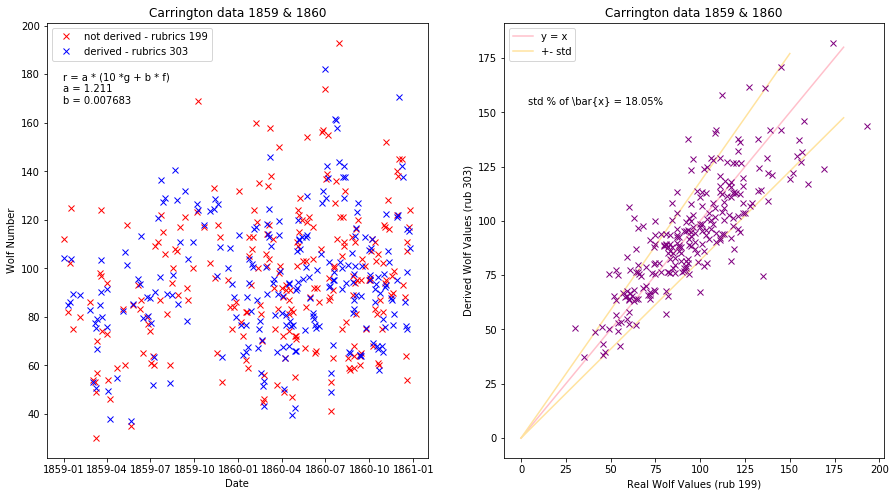

In [3]:
# 1) least squares fitting using non-modified groups

# r = a * (10 g + b * f) = 10 a * g + c * f
# Best fit model with 2 degrees of freedom
def r(gf,a,b):
    g=gf[0]
    f=gf[1]
    return a * (10 *g + b * f)

# takes gf,a,b and returns wolf numbers
def r2(gf,a=1.2111109306343617,b=0.007682607312442986):
    g=gf[0]
    f=gf[1]
    wolf = []
    for i in range(len(g)):
        wolf.append(a*(10*g[i] + b * f[i]))
    return wolf

# takes lists of same length
def standard_deviation(model,data):
    var = 0
    n = len(data)
    for i in range(n):
        var += (model[i]-data[i])**2
    var /= n-1
    std = np.sqrt(var)
    return std

def standard_deviation_percent(model,data):
    var = 0
    n = len(data)
    for i in range(n):
        var += ((model[i]-data[i])/model[i])**2
    var /= n-1
    std = 100*np.sqrt(var)
    return std


# fit and find the parameters a and b
p0 = 1.4,0.15
popt, pcov = curve_fit(r,[ygroups303,ysunspots303],ywolf199,p0)

a = popt[0]
b = popt[1]
print("fit parameter a :",popt[0])
print("fit parameter b :",popt[1])
print("covariance matrix:"); print(pcov)
print()

wolf_adjusted_303 = r2([ygroups303,ysunspots303],a,b)

std = standard_deviation(ywolf199,wolf_adjusted_303)
std_percent_of_mean = standard_deviation_percent(ywolf199,wolf_adjusted_303)

# plotting the fit would require 3 dimensions so I will just plot the residuals
plt.figure(figsize=(15,8))
plt.subplot(121)

plt.title("Carrington data 1859 & 1860")
plt.plot(date199,ywolf199,"rx",label="not derived - rubrics 199")
plt.plot(date303,wolf_adjusted_303,"bx",label="derived - rubrics 303")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Wolf Number")

plt.subplot(122)

plt.title("Carrington data 1859 & 1860")
plt.plot(np.linspace(0,180,200),np.linspace(0,180,200),"-",color="pink",label="y = x")
plt.plot(np.linspace(0,180,200),np.linspace(0,180*(1-std_percent_of_mean/100),200),"-",color="#ffe39f",label="+- std")
plt.plot(np.linspace(0,150,200),np.linspace(0,150*(1+std_percent_of_mean/100),200),"-",color="#ffe39f")
plt.plot(ywolf199,wolf_adjusted_303,"x",color="purple")
plt.legend()
plt.xlabel("Real Wolf Values (rub 199)")
plt.ylabel("Derived Wolf Values (rub 303)")



plt.figtext(0.57, 0.74, "std % of \\bar{x} = "+str(round(std_percent_of_mean,2))+"%")
plt.figtext(0.14,0.74,'r = a * (10 *g + b * f)\na = '+str(round(a,3))+'\nb = '+str(round(b,6)))

# calculate the standard deviation of my estimates from the real thing

plt.savefig("carrington_fit_wolf.png")
plt.show()


In [4]:
# get carrington's data afresh (all of it!)
# message to future person: if these do not load, look in pickles folder for the dictionaries, I pickled them
"""
carrington303_dic,carrington199_dic = graphs_helper.get_full_carrington_dictionaries()

# pickle it for future use
f = open("carrington303_dic_full.pickle","wb")
pickle.dump(carrington303_dic,f)
f.close()
f = open("carrington199_dic_full.pickle","wb")
pickle.dump(carrington199_dic,f)
f.close()"""

##################################################################
# unpickle the pickles
f = open("pickles/carrington199_dic_full.pickle","rb")
carrington199_dic = pickle.load(f)
f.close()
f = open("pickles/carrington303_dic_full.pickle","rb")
carrington303_dic = pickle.load(f)
f.close()
##################################################################

# from the groups and the penumbras
date,g,f=[],[],[]
for d in carrington303_dic:
    g.append(carrington303_dic[d][0])
    f.append(carrington303_dic[d][1])
    date.append(d)
for i in range(len(g)):
    if g[i]==None:
        g[i]=0
    if f[i]==None:
        f[i]=0

# create the wolf numbers for all of carrington's rubrics 303
wolf = r2(gf=[g,f],a=1.2111109306343617,b=0.007682607312442986)
wolf = graphs_helper.round_to_int(wolf)
sunspots = graphs_helper.get_sunspots(g,wolf)

carrington_303_derived_dic = {}
for i in range(len(date)):
    carrington_303_derived_dic[date[i]]=[g[i],sunspots[i],wolf[i]]

# pickle carrington's rubrics 303 derived dictionary
f = open("carrington_303_derived_dic.pickle","wb")
pickle.dump(carrington_303_derived_dic,f)
f.close()
print("carrington_303_derived_dic pickled")

carrington_303_derived_dic pickled


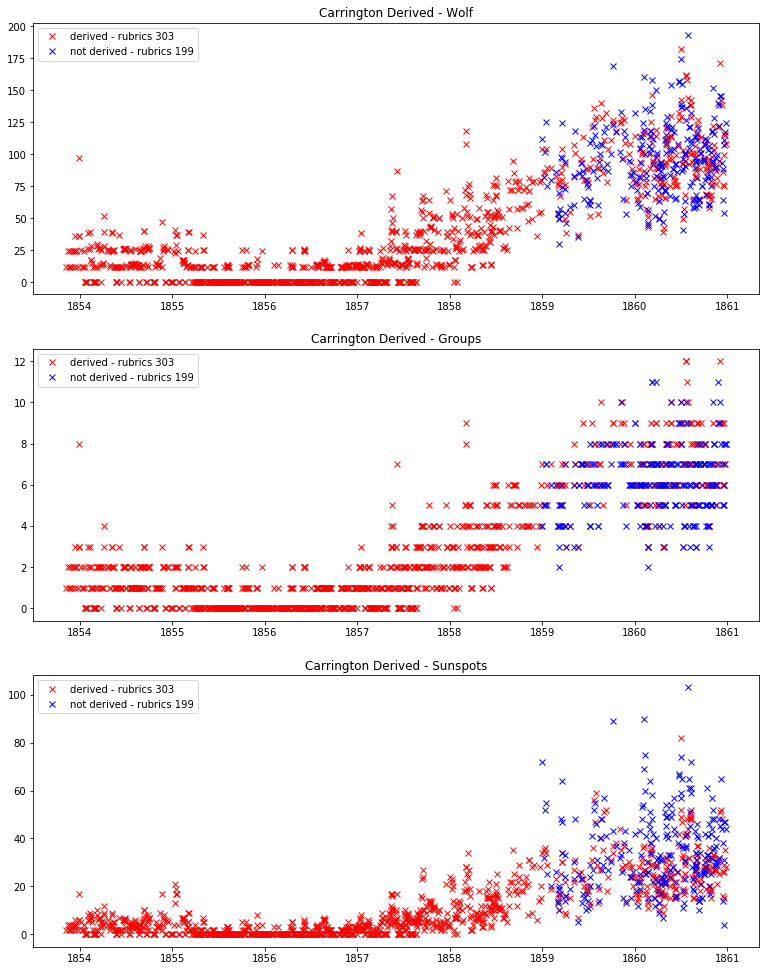

In [5]:
# put the dictionary's contents into lists for plotting purpouses
dates303,groups303,sunspots303,wolf303=[],[],[],[]
for date in carrington_303_derived_dic:
    dates303.append(date)
    groups303.append(carrington_303_derived_dic[date][0])
    sunspots303.append(carrington_303_derived_dic[date][1])
    wolf303.append(carrington_303_derived_dic[date][2])
    
dates199,groups199,sunspots199,wolf199=[],[],[],[]
for date in carrington199_dic:
    dates199.append(date)
    groups199.append(carrington199_dic[date][0])
    sunspots199.append(carrington199_dic[date][1])
    wolf199.append(carrington199_dic[date][2])
    
plt.figure(figsize=(13,17))

plt.subplot(311)
plt.title("Carrington Derived - Wolf")
plt.plot(dates303,wolf303,"rx",label="derived - rubrics 303")
plt.plot(dates199,wolf199,"bx",label="not derived - rubrics 199")
plt.legend()

plt.subplot(312)
plt.title("Carrington Derived - Groups")
plt.plot(dates303,groups303,"rx",label="derived - rubrics 303")
plt.plot(dates199,groups199,"bx",label="not derived - rubrics 199")
plt.legend()

plt.subplot(313)
plt.title("Carrington Derived - Sunspots")
plt.plot(dates303,sunspots303,"rx",label="derived - rubrics 303")
plt.plot(dates199,sunspots199,"bx",label="not derived - rubrics 199")
plt.legend()

plt.savefig("carrington_derived.png")
plt.show()

The next section is gonna be commented out because it should only be run once ever. I am leaving it there so that future me can come back and inspect what I did

**It was successfully executed!!!! hurray!**

In [7]:
"""

# for each entry in the dictionary insert it into the database

# CONNECT 
cursor,mydb = db_connection.database_connector(the_database="DATA_SILSO_HISTO")

for d in carrington_303_derived_dic:
    date = str(d)
    groups,sunspots,wolf = carrington_303_derived_dic[d][0],carrington_303_derived_dic[d][1],carrington_303_derived_dic[d][2]
    
    db_edit.insert_old_format(date=date,fk_rubrics=1010,fk_observers=36,groups=groups,sunspots=sunspots,wolf=wolf,comment='derived',date_insert='2019-07-08 16:17:00',flag=7, the_database="DATA_SILSO_HISTO",id_number=None)

db_connection.close_database_connection(mydb)
"""




mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success


mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection success

TypeError: close_database_connection() missing 1 required positional argument: 'mydb'

In [8]:
# copy all the data from rubrics 303 with FK_RUBRICS=1010 into GOOD_DATA_SILSO
"""

# select all the ids that I want to copy 
cursor,mydb = db_connection.database_connector(the_database="DATA_SILSO_HISTO")
query =  "SELECT * FROM DATA WHERE FK_RUBRICS=1010"
cursor.execute(query,())
data = cursor.fetchall()
db_connection.close_database_connection(mydb)

# connect to both
cursor,mydb = db_connection.database_connector(the_database="DATA_SILSO_HISTO")
cursor2,mydb2 = db_connection.database_connector(the_database="GOOD_DATA_SILSO")
for i in data:
    id_number = i[0]
    db_transfers.db_transfer(id_number=id_number,sender="DATA_SILSO_HISTO",recipient="GOOD_DATA_SILSO",cursor=cursor,mydb=mydb,cursor2=cursor2,mydb2=mydb2,close_connections=False,dont_delete=True)
   
    
# close the connection
db_connection.close_database_connection(mydb)
db_connection.close_database_connection(mydb2)

"""


mysql connection successfully established with DATA_SILSO_HISTO
Closing MySQL connection...

mysql connection successfully established with DATA_SILSO_HISTO

mysql connection successfully established with GOOD_DATA_SILSO
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to databa

successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
succes

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
succes

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a

Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data added to database
successfully fetched data from DATA_SILSO_HISTO
Data a


mysql connection successfully established with DATA_SILSO_HISTO
data successfully retrieved
Closing MySQL connection...

mysql connection successfully established with DATA_SILSO_HISTO
observers sucessfully retrieved
Closing MySQL connection...


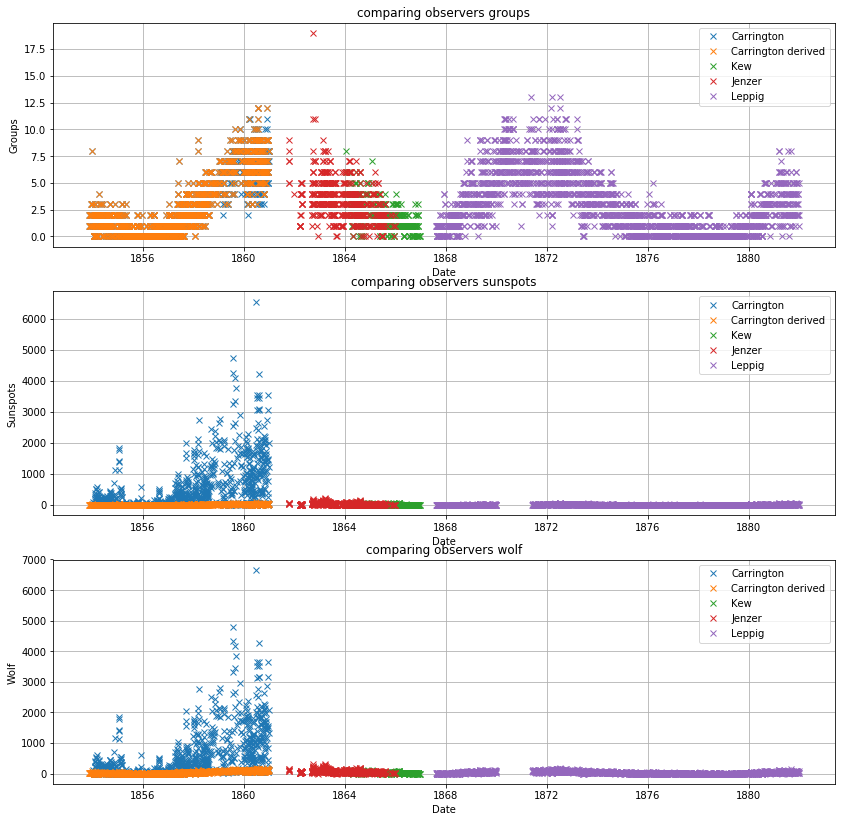

In [17]:
display_compare_observers(["Carrington","Carrington derived","Kew","Jenzer","Leppig"],
                          save_as="carrington_kew_after_fix.png",
                          figsize=(14,14))#,
                          #the_database="GOOD_DATA_SILSO")



mysql connection successfully established with DATA_SILSO_HISTO
data successfully retrieved
Closing MySQL connection...

mysql connection successfully established with DATA_SILSO_HISTO
observers sucessfully retrieved
Closing MySQL connection...


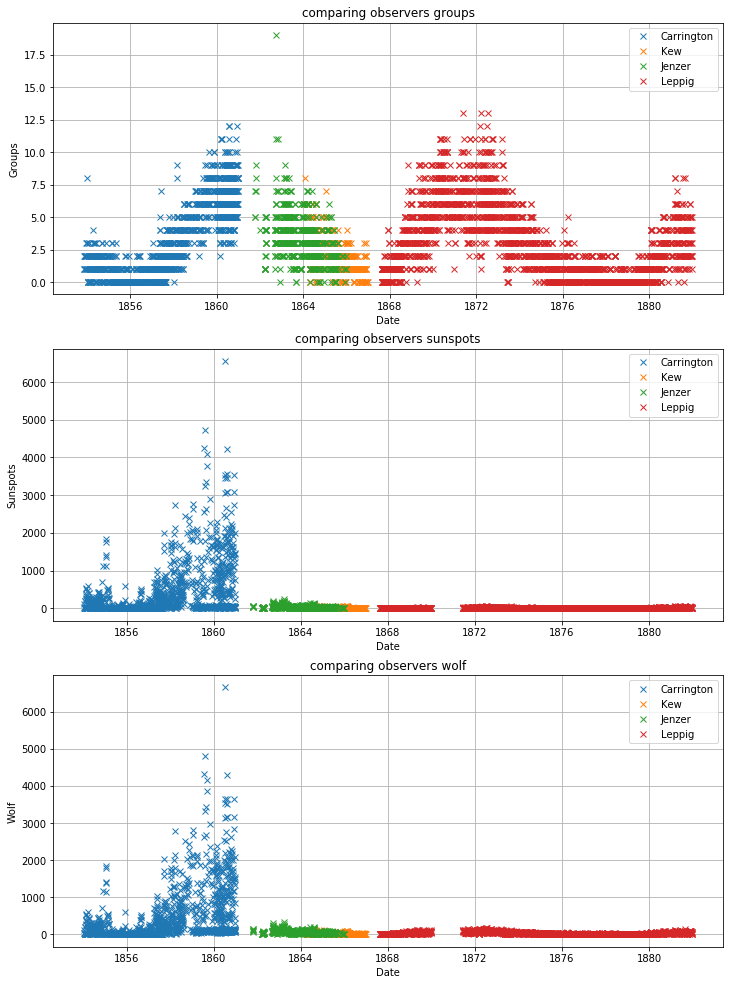

In [4]:
display_compare_observers(["Carrington","Kew","Jenzer","Leppig"])